<a href="https://colab.research.google.com/github/MUHOOZId/MUHOOZId/blob/main/MalwareProject_Final_with_Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Python code to implement a Random Forest model for malware classification using the provided malware_features_datasetq.csv and family_labels.csv datasets. The dataset was made by extracting features using YARA rules. It includes data preprocessing, model training, evaluation, and visualization.



In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Step 1: Load the datasets

In [2]:
# Step 1: Load the datasets
features_df = pd.read_csv('malware_features_datasetq.csv', low_memory=False)
labels_df = pd.read_csv('family_labels.csv')

print("✅ Features dataset loaded successfully.")
print(f"Features dataset shape: {features_df.shape}")
print(f"Features dataset sample:\n{features_df.head()}")

print("\n✅ Labels dataset loaded successfully.")
print(f"Labels dataset shape: {labels_df.shape}")
print(f"Labels dataset sample:\n{labels_df.head()}")

✅ Features dataset loaded successfully.
Features dataset shape: (86536, 151)
Features dataset sample:
  source                                           filename  EntryPoint  \
0   out1  000054e0b7668fe5501e3f6e9419e70d90733d5c33b509...       52080   
1   out1  0004024788c23eafde6dbcc9da8aaa90c50a8137678ba3...       11439   
2   out1  0005a62c933ba8bed50eab0a2b9da0b3d6f395fa6b6713...       11161   
3   out1  00093737b0b4bbe0535669f3b04af7c2be754a6e150476...        1696   
4   out1  000e6412bebb9b90ee7f463a985a441881953da63c4486...      573028   

   FromBegin  FromEnd                                        EntryHash10  \
0      52080  1756319  5c06f50018c1a97a50a682ed5dd36ba71f37379dab4fa6...   
1      11439  4535922  165e9d02f19660b445704f253df3801a64cd01237a0ebe...   
2      11161   409412  15b2caf2f5f3b6c8ff3a8a9ed5a016496dc4254d6873a1...   
3       1696   521969  4456e40f778fd5d2880da208588bacadb0fbb332c06054...   
4     573028  2616402  5878d7264c3b9554e8287b229ef7f9b5c09cf49db5ab

# Step 2: Preprocess filenames in features_df (remove .txt extension)

In [3]:
# Step 2: Preprocess filenames in features_df (remove .txt extension)
features_df['filename'] = features_df['filename'].str.replace('.txt', '', regex=False).str.lower().str.strip()
labels_df['filename'] = labels_df['filename'].str.lower().str.strip()

print("\n🔹 Filename preprocessing complete.")
print(f"Features dataset filenames sample:\n{features_df['filename'].head()}")
print(f"Labels dataset filenames sample:\n{labels_df['filename'].head()}")


🔹 Filename preprocessing complete.
Features dataset filenames sample:
0    000054e0b7668fe5501e3f6e9419e70d90733d5c33b509...
1    0004024788c23eafde6dbcc9da8aaa90c50a8137678ba3...
2    0005a62c933ba8bed50eab0a2b9da0b3d6f395fa6b6713...
3    00093737b0b4bbe0535669f3b04af7c2be754a6e150476...
4    000e6412bebb9b90ee7f463a985a441881953da63c4486...
Name: filename, dtype: object
Labels dataset filenames sample:
0    0000c252e7b4e2a5b0a004b0158d6d94
1    000302ca4394c78694447fb6530b5a0f
2    000357eba8e39684f5a5b19f45793417
3    000485d70d3c9eeb9972b102cd3e07f5
4    00054e8d8d8baed7e43cbb65d8eee704
Name: filename, dtype: object


# Step 3: Merge datasets

In [4]:
# Step 3: Merge datasets
merged_df = pd.merge(features_df, labels_df[['filename', 'family_name']],
                     on='filename', how='inner')
print("Merged Data Shape:", merged_df.shape)
if merged_df.empty:
    print("Error: Merged DataFrame is empty. Check filename matches.")
    common_filenames = set(features_df['filename']).intersection(set(labels_df['filename']))
    print("Common filenames:", common_filenames)
    print("Number of common filenames:", len(common_filenames))
    raise ValueError("No matching filenames found. Verify datasets.")
else:
    print("Merged Data Sample:\n", merged_df.head())

Merged Data Shape: (2484, 152)
Merged Data Sample:
   source                          filename  EntryPoint  FromBegin  FromEnd  \
0   out4  0000c252e7b4e2a5b0a004b0158d6d94       14069      14069   270603   
1   out4  000302ca4394c78694447fb6530b5a0f       38430      38430     3042   
2   out4  000357eba8e39684f5a5b19f45793417     2582144    2582144  1042904   
3   out4  000485d70d3c9eeb9972b102cd3e07f5     2889431    2889431  1902889   
4   out4  00054e8d8d8baed7e43cbb65d8eee704      683948     683948   173340   

                                         EntryHash10  \
0  8421f91579c4ed48b47308d148cf2e711d49464841cdfc...   
1  65c49144b6a3d2ee6fe509adb98f6a62e8107b620fb3b0...   
2  ec250cbafbbe963788a85f69c6adb6842da06d29007009...   
3  5ab971d2de25d883cbe268296b571912b7de5f60121354...   
4  5e69e7215d75e38c723905802947c3c5d21bd4a72e6c51...   

                                         EntryHash20  \
0  0f3ab3e6f293f0a71243f99242b6a1059c11a7a4f7918e...   
1  869c02d70115474a63ddd5a8544

# Step 4: Filter out 'unknown' and '2345' family labels

In [5]:
# Step 4: Filter out 'unknown' and '2345' family labels
merged_df = merged_df[~merged_df['family_name'].isin(['unknown', '2345'])].reset_index(drop=True)
print("Shape after removing 'unknown' and '2345' labels:", merged_df.shape)

Shape after removing 'unknown' and '2345' labels: (2344, 152)


# Step 5: Define categorical and numerical columns

In [6]:
# Step 5: Define categorical and numerical columns
categorical_cols = ['SectionName_0', 'SectionName_1', 'SectionName_2',
                    'SectionName_3', 'SectionName_4', 'EntryHash10', 'Imphash']
numerical_cols = [col for col in merged_df.columns if col not in categorical_cols +
                  ['filename', 'family_name']]

# Step 6: Handle missing values and mixed types
# Categorical: Fill NaN with 'Unknown' and ensure string type
for col in categorical_cols:
    merged_df[col] = merged_df[col].astype(str).fillna('Unknown')

# Numerical: Convert to numeric, fill NaN with median
for col in numerical_cols:
    merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')
    merged_df[col] = merged_df[col].fillna(merged_df[col].median())

# Step 7: Drop columns with zero variance or high NaN values (>80%)

In [7]:
# Step 7: Drop columns with zero variance or high NaN values (>80%)
zero_variance_cols = [col for col in numerical_cols if merged_df[col].var() == 0]
high_nan_cols = [col for col in numerical_cols if merged_df[col].isna().mean() > 0.8]
cols_to_drop = list(set(zero_variance_cols + high_nan_cols))
if cols_to_drop:
    print("Dropping columns:", cols_to_drop)
    merged_df = merged_df.drop(columns=cols_to_drop)
    numerical_cols = [col for col in numerical_cols if col not in cols_to_drop]

# Verify no remaining NaN values
print("Missing Values after preprocessing:\n", merged_df.isna().sum())

Dropping columns: ['SignatureSubject', 'MagicType', 'SectionName_22', 'SectionName_23', 'SectionRawSize_22', 'SectionCharacteristics_15', 'SectionVSIZE_13', 'SectionName_9', 'SectionName_15', 'SignatureIssuer', 'SectionName_11', 'SectionCharacteristics_20', 'EntryHash40', 'SectionRawSize_16', 'SectionName_6', 'SectionRawSize_12', 'SectionVSIZE_19', 'SectionCharacteristics_22', 'SectionVSIZE_16', 'SectionVSIZE_12', 'SectionRawSize_15', 'SectionVA_11', 'SignatureAlgorithm', 'SectionVSIZE_17', 'SectionRawSize_18', 'SectionVA_17', 'SectionVSIZE_11', 'SectionVA_14', 'SectionCharacteristics_10', 'SectionCharacteristics_17', 'MimeType', 'SectionCharacteristics_14', 'SectionRawSize_23', 'SectionVA_22', 'SectionRawSize_19', 'SectionName_18', 'source', 'SectionVSIZE_22', 'SectionRawSize_17', 'EntryHash20', 'SectionCharacteristics_13', 'SectionVSIZE_18', 'SectionName_8', 'SectionVSIZE_21', 'SectionRawSize_21', 'SectionCharacteristics_21', 'SectionRawSize_10', 'SectionVA_21', 'SectionVA_23', 'Sect

# Step 8: Encode categorical features

In [8]:
# Step 8: Encode categorical features
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    merged_df[col] = le.fit_transform(merged_df[col])
    label_encoders[col] = le

# Step 9: Normalize numerical features
scaler = StandardScaler()
merged_df[numerical_cols] = scaler.fit_transform(merged_df[numerical_cols])

# Step 10: Group similar families to reduce the number of classes

In [9]:

# Step 10: Group similar families to reduce the number of classes
family_mapping = {
    'Kryptik': 'Kryptik',
    'Kryptik_AGen': 'Kryptik',
    'GenKryptik': 'Kryptik',

    'Agent': 'Agent',
    'Agent_AGen': 'Agent',

    'Trojan': 'Trojan',
    'Trojan-Dropper': 'Trojan',
    'TrojanDropper': 'Trojan',
    'TrojanDownloader': 'Trojan',
    'TrojanClicker': 'Trojan',
    'TrojanProxy': 'Trojan',

    'Qbot': 'Qbot',
    'Qbot_AGen': 'Qbot',

    'Spy': 'Spy',
    'SpyVoltar': 'Spy',
    'Spybot': 'Spy',

    'VB': 'VB',
    'VBClone': 'VB',
    'VBObfus': 'VB',

    'AutoRun': 'AutoRun',
    'Autorun': 'AutoRun',

    'Exploit': 'Exploit',
    'Exploit-DcomRpc': 'Exploit',

    'PWSZbot-FAPM': 'PWSZbot',
    'RemAdm-RemoteAdmin': 'RemAdm',
    'BackDoor-FCZS': 'BackDoor',
    'HTool-TermServ': 'HTool'
}
merged_df['family_name'] = merged_df['family_name'].replace(family_mapping)

# Step 11: Filter out classes with fewer than 2 samples

In [10]:
# Step 11: Filter out classes with fewer than 2 samples
le_family_original = LabelEncoder()
merged_df['family_name'] = le_family_original.fit_transform(merged_df['family_name'])
class_counts = pd.Series(le_family_original.inverse_transform(merged_df['family_name'])).value_counts()
valid_classes = class_counts[class_counts >= 2].index
mask = pd.Series(le_family_original.inverse_transform(merged_df['family_name']), index=merged_df.index).isin(valid_classes)
merged_df = merged_df[mask].reset_index(drop=True)
print("Classes after filtering (min 2 samples):", le_family_original.classes_)
print("Class Distribution after filtering:\n", pd.Series(le_family_original.inverse_transform(merged_df['family_name'])).value_counts())


Classes after filtering (min 2 samples): ['AHK' 'Adaware' 'Adware' 'Agent' 'Ainslot' 'Allaple' 'AlteredSoftware'
 'Alyak' 'Amonetize' 'Application' 'Artemis' 'Asbit' 'Asterope' 'AsyncRAT'
 'AutoRun' 'Autoit' 'BHO' 'BackDoor' 'Baidence' 'Bandok' 'Bayrob' 'Bedep'
 'Bflient' 'Bifrose' 'Bladabindi' 'Boaxxe' 'Brontok' 'BrowsingHistoryView'
 'Bumblebee_AGen' 'Bundpil' 'ClipBanker' 'CobaltStrike' 'CoinMiner'
 'Conduit' 'Cosmu' 'Cryptociselo' 'DealPly' 'Delf' 'Dialer' 'Disabler'
 'Disdroth' 'DivX' 'Dlhelper' 'DomaIQ' 'Dorkbot' 'DownloadAdmin'
 'DownloadAssistant' 'DownloadSponsor' 'Dridex' 'Eggnog' 'Enchanim'
 'Expiro' 'Exploit' 'ExtenBro' 'FakeDoc' 'FakeTool' 'Farfli' 'Fignya'
 'Filecoder' 'Filesponger' 'Flooder' 'Floxif' 'FlyStudio' 'Formbook'
 'Fusing' 'Futu' 'Fynloski' 'GameHack' 'Goblin' 'HTool' 'HackKMS'
 'HackTool' 'HideBaid' 'Hupigon' 'IStartSurf' 'Immirat' 'Injector'
 'InstallCore' 'InstallIQ' 'InstallMonetizer' 'InstallMonstr' 'Jeefo'
 'Kasidet' 'Kelihos' 'KeyLogger' 'Keygen' 'Kovter

# Step 12: Focus on top 10 classes

In [11]:
# Step 12: Focus on top 10 classes
top_classes = pd.Series(le_family_original.inverse_transform(merged_df['family_name'])).value_counts().head(10).index
mask = pd.Series(le_family_original.inverse_transform(merged_df['family_name']), index=merged_df.index).isin(top_classes)
merged_df = merged_df[mask].reset_index(drop=True)
# Re-encode the target for the top 10 classes
le_family = LabelEncoder()
merged_df['family_name'] = le_family.fit_transform(merged_df['family_name'])
print("Top 10 Classes (encoded):", le_family.classes_)
print("Class Distribution (Top 10):\n", pd.Series(le_family.inverse_transform(merged_df['family_name'])).value_counts())


Top 10 Classes (encoded): [  2   3  10  14  32  76  87 140 150 154]
Class Distribution (Top 10):
 87     381
2      222
150    194
3      168
76     148
32      91
140     84
10      71
154     52
14      52
Name: count, dtype: int64


# Step 13: Select features and target

In [12]:
# Step 13: Select features and target
X = merged_df.drop(['filename', 'family_name'], axis=1)
y = merged_df['family_name']
print("Features Shape:", X.shape)
print("Target Shape:", y.shape)
print("Remaining Features:", X.columns.tolist())

Features Shape: (1463, 66)
Target Shape: (1463,)
Remaining Features: ['EntryPoint', 'FromBegin', 'FromEnd', 'EntryHash10', 'Characteristics', 'IsDLL', 'LARGE_ADDRESS_AWARE', 'OS_Version', 'Subsystem', 'Machine', 'SizeOfCode', 'InitializedData', 'SizeOfHeapReserve', 'SizeOfStackReserve', 'NumberOfResources', 'NumberOfSections', 'NumberOfImportedFunctions', 'Imphash', 'SectionName_0', 'SectionVA_0', 'SectionVSIZE_0', 'SectionRawSize_0', 'SectionCharacteristics_0', 'SectionName_1', 'SectionVA_1', 'SectionVSIZE_1', 'SectionRawSize_1', 'SectionCharacteristics_1', 'SectionName_2', 'SectionVA_2', 'SectionVSIZE_2', 'SectionRawSize_2', 'SectionCharacteristics_2', 'SectionName_3', 'SectionVA_3', 'SectionVSIZE_3', 'SectionRawSize_3', 'SectionCharacteristics_3', 'SectionName_4', 'SectionVA_4', 'SectionVSIZE_4', 'SectionRawSize_4', 'SectionCharacteristics_4', 'Checksum', 'CalculatedChecksum', 'Timestamp', 'SectionVA_5', 'SectionVSIZE_5', 'SectionRawSize_5', 'SectionCharacteristics_5', 'SectionVA_6'

# Step 14: Split data

In [13]:
# Step 14: Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=42, stratify=y)
print("Training Set Shape:", X_train.shape)
print("Test Set Shape:", X_test.shape)

Training Set Shape: (1024, 66)
Test Set Shape: (439, 66)


# Step 15: Filter classes in y_train with fewer than 2 samples

Training Classes after filtering (min 2 samples): [  2   3  10  14  32  76  87 140 150 154]
Training Class Distribution after filtering:
 2      155
3      117
10      50
14      36
32      64
76     104
87     267
140     59
150    136
154     36
Name: count, dtype: int64
Test Classes after filtering: [  2   3  10  14  32  76  87 140 150 154]
Test Class Distribution after filtering:
 2       67
3       51
10      21
14      16
32      27
76      44
87     114
140     25
150     58
154     16
Name: count, dtype: int64
Adjusted Training Set Shape: (1024, 66)
Adjusted Test Set Shape: (439, 66)


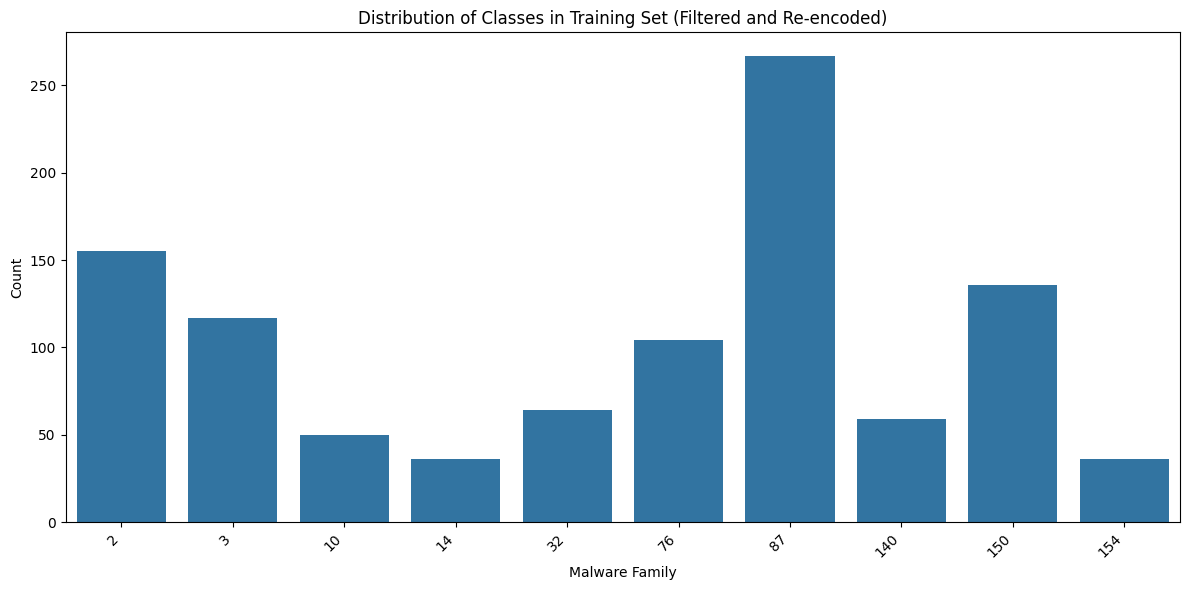

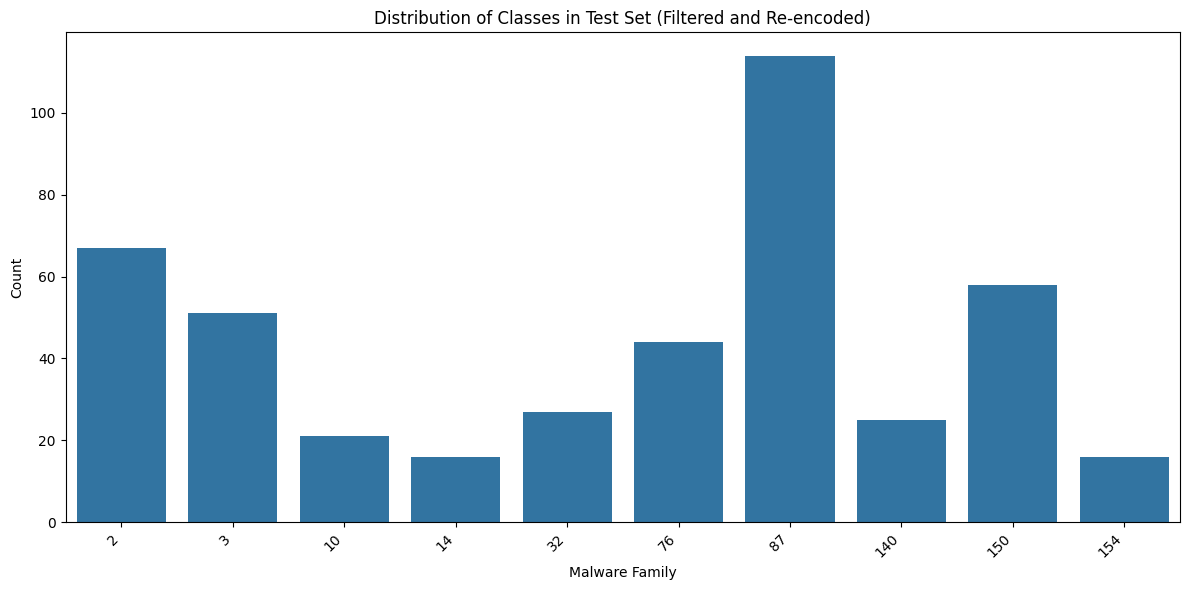

In [14]:

# Step 15: Filter classes in y_train with fewer than 2 samples
train_class_counts = pd.Series(le_family.inverse_transform(y_train)).value_counts()
valid_train_classes = train_class_counts[train_class_counts >= 2].index
train_mask = pd.Series(le_family.inverse_transform(y_train), index=X_train.index).isin(valid_train_classes)
X_train = X_train[train_mask].reset_index(drop=True)
y_train = y_train[train_mask].reset_index(drop=True)

# Get the class names (strings) and re-encode y_train
train_class_names = le_family.inverse_transform(np.unique(y_train))  # Convert encoded labels to string names
le_family_train = LabelEncoder()
y_train_encoded = le_family_train.fit_transform(le_family.inverse_transform(y_train))  # Re-encode using the string names
# Map the encoded labels back to strings for printing
train_class_distribution = pd.Series(y_train_encoded).value_counts().sort_index()
train_class_distribution.index = train_class_names[train_class_distribution.index]
print("Training Classes after filtering (min 2 samples):", train_class_names)
print("Training Class Distribution after filtering:\n", train_class_distribution)

# Adjust y_test to match the filtered training classes
test_mask = pd.Series(le_family.inverse_transform(y_test), index=X_test.index).isin(train_class_names)
X_test = X_test[test_mask].reset_index(drop=True)
y_test = y_test[test_mask].reset_index(drop=True)
# Re-encode y_test to match y_train's encoding
y_test_encoded = le_family_train.transform(le_family.inverse_transform(y_test))
# Map the encoded labels back to strings for printing
test_class_distribution = pd.Series(y_test_encoded).value_counts().sort_index()
test_class_distribution.index = train_class_names[test_class_distribution.index]
print("Test Classes after filtering:", train_class_names)
print("Test Class Distribution after filtering:\n", test_class_distribution)
print("Adjusted Training Set Shape:", X_train.shape)
print("Adjusted Test Set Shape:", X_test.shape)

plt.figure(figsize=(12, 6))
sns.countplot(x=le_family_train.inverse_transform(y_train_encoded), order=train_class_names)
plt.title('Distribution of Classes in Training Set (Filtered and Re-encoded)')
plt.xlabel('Malware Family')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.countplot(x=le_family_train.inverse_transform(y_test_encoded), order=train_class_names)
plt.title('Distribution of Classes in Test Set (Filtered and Re-encoded)')
plt.xlabel('Malware Family')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Step 16: Apply SMOTE to balance classes


Balanced Training Set Shape: (2670, 66)
Balanced Class Distribution:
 2      267
3      267
10     267
14     267
32     267
76     267
87     267
140    267
150    267
154    267
Name: count, dtype: int64


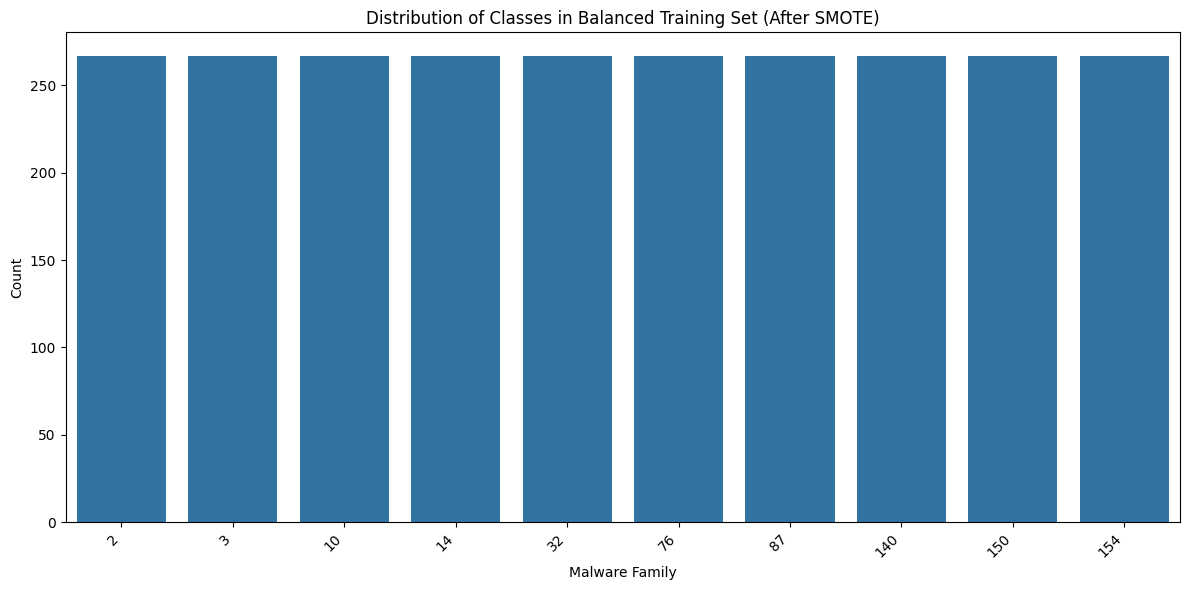

In [15]:
# Step 16: Apply SMOTE to balance classes
smote = SMOTE(random_state=42, k_neighbors=1)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train_encoded)
# Map the encoded labels back to strings for printing
balanced_class_distribution = pd.Series(y_train_balanced).value_counts().sort_index()
balanced_class_distribution.index = train_class_names[balanced_class_distribution.index]
print("Balanced Training Set Shape:", X_train_balanced.shape)
print("Balanced Class Distribution:\n", balanced_class_distribution)

# Step 17: Train Random Forest with optimized parameters
rf_model = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42,
                                  class_weight='balanced', n_jobs=-1)
rf_model.fit(X_train_balanced, y_train_balanced)
y_pred = rf_model.predict(X_test)

plt.figure(figsize=(12, 6))
sns.countplot(x=le_family_train.inverse_transform(y_train_balanced), order=train_class_names)
plt.title('Distribution of Classes in Balanced Training Set (After SMOTE)')
plt.xlabel('Malware Family')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Step 18: Evaluate model

In [ ]:
# Step 18: Evaluate model
accuracy = accuracy_score(y_test_encoded, y_pred)
precision = precision_score(y_test_encoded, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test_encoded, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test_encoded, y_pred, average='weighted', zero_division=0)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.7016
Precision: 0.7036
Recall: 0.7016
F1-Score: 0.7004


# Step 19: Fix class names for human-readable reporting

In [ ]:
# Step 19: Fix class names for human-readable reporting
target_names_human = le_family.inverse_transform(sorted(np.unique(y_test_encoded)))
target_names_human = [str(name) for name in target_names_human]  # Ensure strings

print("\n📊 Per-Class Metrics:")
print(classification_report(
    y_test_encoded,
    y_pred,
    target_names=target_names_human,
    zero_division=0
))



📊 Per-Class Metrics:
              precision    recall  f1-score   support

           2       0.86      0.88      0.87        67
           3       0.64      0.75      0.69        51
          10       0.33      0.29      0.31        21
          14       0.59      0.62      0.61        16
          32       0.96      0.96      0.96        27
          76       0.43      0.52      0.47        44
          87       0.82      0.79      0.80       114
         140       0.67      0.48      0.56        25
         150       0.59      0.52      0.55        58
         154       0.82      0.88      0.85        16

    accuracy                           0.70       439
   macro avg       0.67      0.67      0.67       439
weighted avg       0.70      0.70      0.70       439



# Step 20: Plot confusion matrix

<ipython-input-54-94faee5dab9a>:11: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


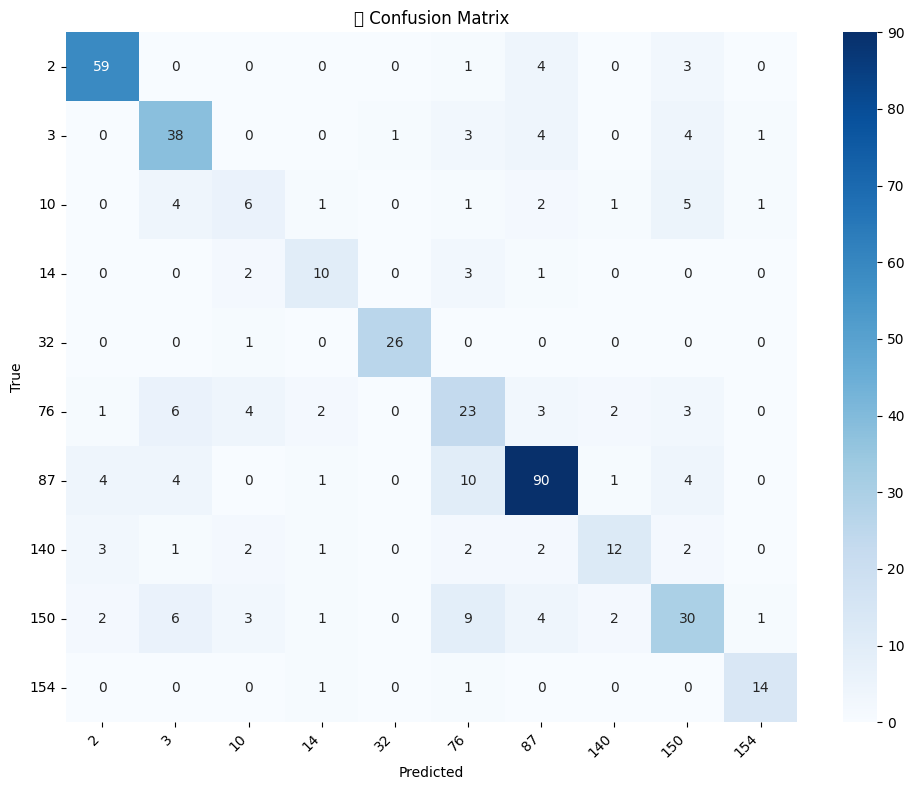

In [ ]:
cm = confusion_matrix(y_test_encoded, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names_human,
            yticklabels=target_names_human)
plt.title('🧠 Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Step 21: Feature importance

<ipython-input-55-adc01a85e2b4>:10: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


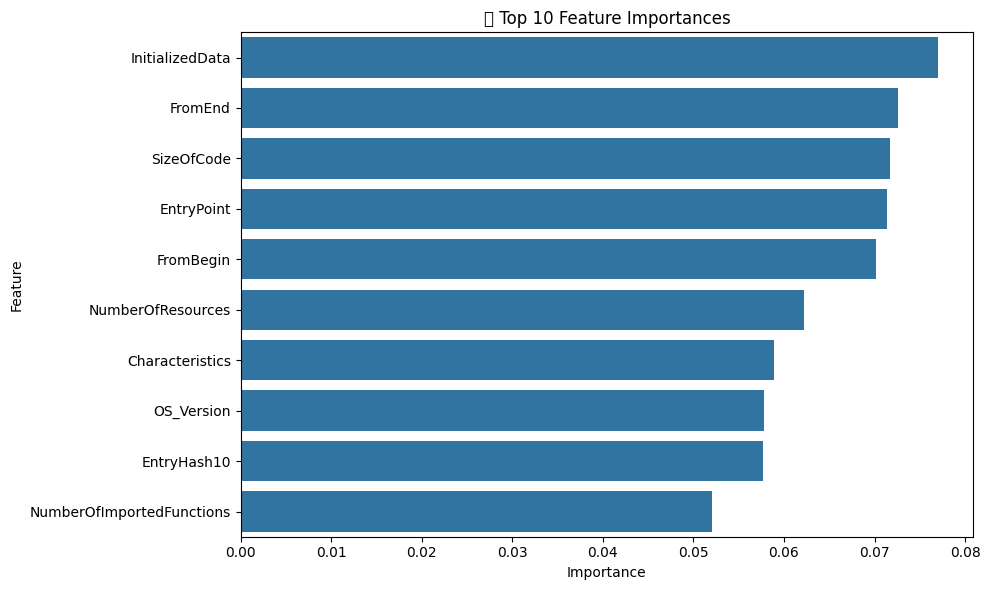

Top 10 Features:
                       Feature  Importance
11            InitializedData    0.077050
2                     FromEnd    0.072554
10                 SizeOfCode    0.071709
0                  EntryPoint    0.071389
1                   FromBegin    0.070200
14          NumberOfResources    0.062218
4             Characteristics    0.058910
7                  OS_Version    0.057812
3                 EntryHash10    0.057647
16  NumberOfImportedFunctions    0.052006


In [ ]:
# Step 21: Feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
plt.title('🔍 Top 10 Feature Importances')
plt.tight_layout()
plt.show()

print("Top 10 Features:\n", feature_importance.head(10))

# Step 22: Save model and encoders

In [ ]:
# Step 22: Save model and encoders
joblib.dump(rf_model, 'final_random_forest_malware_model.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(le_family, 'family_label_encoder.pkl')

# Save evaluation results to file
with open('final_rf_evaluation_results.txt', 'w') as f:
    f.write(f"Accuracy: {accuracy:.4f}\n")
    f.write(f"Precision: {precision:.4f}\n")
    f.write(f"Recall: {recall:.4f}\n")
    f.write(f"F1-Score: {f1:.4f}\n")
    f.write("\nClassification Report:\n")
    f.write(classification_report(
        y_test_encoded,
        y_pred,
        target_names=target_names_human,
        zero_division=0
    ))
